In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
!pip install --upgrade pandas
!pip install --upgrade xlrd
import pandas as pd # Para manejo de base de datos

     |████████████████████████████████| 96 kB 2.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Ahora, traigamos el data set. En particular, usemos un data set propio del [INTA](http://siga2.inta.gov.ar/#/data), que registra temperaturas mínimas y máximas, precipitaciones, humedad y más para un día (en este caso, usamos las de San Fernando). En este caso, tenemos datos desde 2018 hasta la actualidad.

In [ ]:
# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2022/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel
d.head() # Mostramos las primeras líneas, para darnos una idea

Mounted at /content/drive


,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_5cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_5cm_Media,Temperatura_Suelo_10cm_Media,Temperatura_Inte_5cm,Temperatura_Intemperie_150cm_Minima,...,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
0,2018-02-08 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,NaN,NaN
1,2018-02-09 00:00:00.0,23.80764,28.6,20.4,NaN,NaN,NaN,26.21042,NaN,NaN,...,NaN,1.332639,C,1.665799,C,19.3,NaN,NaN,0.0,-23.904030
2,2018-02-10 00:00:00.0,24.51389,31.7,19.4,NaN,NaN,NaN,26.45972,NaN,NaN,...,NaN,1.638195,C,2.047743,C,19.0,NaN,NaN,0.0,-23.904030
3,2018-02-11 00:00:00.0,19.50139,24.2,15.1,NaN,NaN,NaN,24.66320,NaN,NaN,...,NaN,3.247224,E,4.059030,C,20.4,NaN,NaN,0.0,-15.106020
4,2018-02-12 00:00:00.0,16.70625,24.6,9.5,NaN,NaN,NaN,22.63611,NaN,NaN,...,NaN,1.027778,C,1.284722,C,13.4,NaN,NaN,0.0,-5.394994


In [ ]:
d_filtrado = d[['Temperatura_Abrigo_150cm_Maxima',
                'Temperatura_Abrigo_150cm_Minima',
                'Precipitacion_Pluviometrica',
                'Velocidad_Viento_Maxima',
                'Rocio_Medio',
                'Humedad_Media']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe
d_filtrado.rename({'Temperatura_Abrigo_150cm_Maxima' : 'temperaturaMaxima',
                   'Temperatura_Abrigo_150cm_Minima' : 'temperaturaMinima',
                   'Precipitacion_Pluviometrica' : 'precipitacion',
                   'Humedad_Media' : 'humedad',
                   'Rocio_Medio' : 'rocio',
                   'Velocidad_Viento_Maxima' : 'viento'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

Teniendo en cuenta que queremos saber si llueve o no llueve un día, vamos a llevar a una categoría binaria la columna precipitación.

Generemos una nueva columna que sea "llueveNollueve" que de cuenta de esto

In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0.
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    717
1    337
Name: llueveNollueve, dtype: int64

# El Modelo

Ya estamos listxs para poder jugar con sklearn y la clasificación.

Vamos a buscar relacionar las características: temperaturaMaxima, temperaturaMinima, humedad con la etiqueta llueveNollueve.

Lo haremos con el objetivo de que, el día de mañana, nos digan: esta es el pronóstico de temperatura y humedad, entonces llueve o no llueve?

### Antes, recordatorio

$$P(y |x, \beta) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 \cdot x)}}$$

es lo que llamamos función sigmoidea para el caso de tener un único feature

In [ ]:
campos = 'temperaturaMinima' # El campo que usaremos como X
X = d_filtrado[campos].values.reshape(-1,1) # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. El .reshape(-1,1) es para llevarlo a la forma matricial que le gusta a sklearn
y = d_filtrado['llueveNollueve'].values # Defino la variable y

regLog = LogisticRegression(penalty = 'none', )   # creamos el objeto classificador. Usamos todo por defecto, excepto que no vamos a usar regularizacion y por eso lo aclaramos
# ahora entrenamos el modelo usando el metodo .fit(X,y) donde X es la matriz de features (dias x variable independiente) e y es el vector de etiquetas (0 si no llueve, 1 si llueve)

regLog.fit(X,  y)

score = regLog.score(X,y) # Es el score del ajuste

beta_0 = regLog.intercept_ # Es el método para obtener el beta 0
beta_1 = regLog.coef_ # Es el método para obtener el beta 1

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas

El score del modelo es de: 0.685


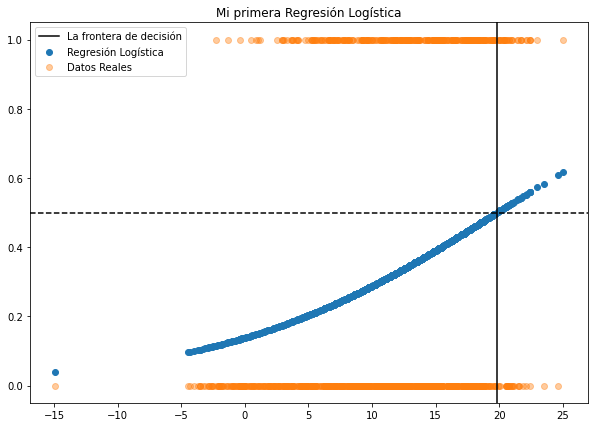

In [ ]:
fig, ax = plt.subplots(figsize = (10,7)) # Generamos la figura
ax.set_title('Mi primera Regresión Logística')

ax.scatter(X, # Los valores X
          1 / (1 + np.e ** -(beta_1 * X + beta_0)), # Las predicciones sobre los valores X
          label = 'Regresión Logística',
          )

ax.scatter(X, # Los valores X
           y, # Los valores reales de Y
           label = 'Datos Reales',
           alpha = 0.4
           )
ax.axvline(- beta_0 / beta_1, # La frontera de decisión.
           color = 'k',
           label = 'La frontera de decisión')
ax.axhline(0.5,
           linestyle = 'dashed',
           color = 'k')
ax.legend()
plt.show()



# Y si usamos dos campos para el entrenamiento?

Veamos ahora qué ocurre si, además de utilizar el campo "temperaturaMinima", usamos también, por ejemplo, "humedad".

In [ ]:
# Definamos la matriz X
campos = ['temperaturaMinima',
          'humedad'] # Lista que contiene las features de interés
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
print(X.shape) # Como vemos, es una matriz de 1054 filas y 2 columnas
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

regLog = LogisticRegression(penalty = 'none') # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas

(1054, 2)
El score del modelo es de: 0.7125


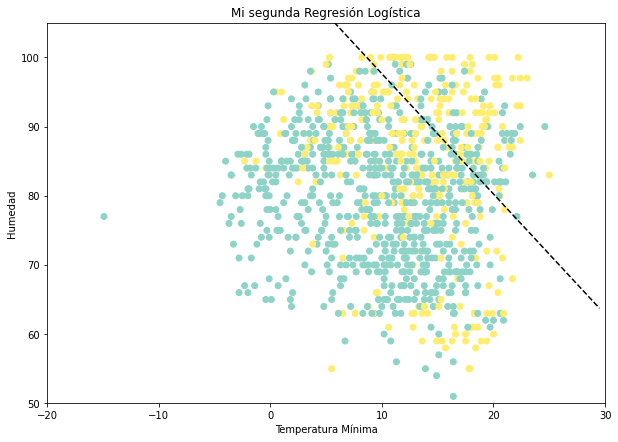

In [ ]:
# Miremos esto en un gráfico

fig, ax = plt.subplots(figsize = (10,7))

ax.set_title('Mi segunda Regresión Logística')
ax.scatter(X[:,0], # Ploteamos la primera columna de nuestra matriz X. Osea, la temperaturaMinima
           X[:,1], # Ploteamos la segunda columna de nuestra matriz X. Osea, la humedad
           c = y, # Les damos color a los puntos según la etiqueta real
           cmap = 'Set3', # El mapa de color
           )
ax.set_xlabel('Temperatura Mínima') # Etiqueta del eje x
ax.set_ylabel('Humedad') # Etiqueta del eje y

# Plotear la curva acá, no sería de mucho interés. Sí podríamos colorear un área como representación de la función P: R² ---> R
# Plotiemos la frontera de decisión

x_1_test = np.arange(-20,30,0.5) # Generamos unas temperaturas de prueba, para plotear la definición de frontera en el caso de dos features como vimos en la teórica
ax.plot(x_1_test,
        - (beta_0 + x_1_test * beta_1) / beta_2, # Generamos el la recta que calculamos en la teórica
        linestyle = 'dashed',
        color = 'k')
#ax.legend()
ax.axis([-20,30,50,105]) # Seteamos los límites de los ejes
plt.show()

# Para llevarse de este Notebook


*   Existe un objeto llamado LogisticRegression en scikit-learn que crea una instancia de regresión logística sin regularización haciendo:

```
regLog = LogisticRegression(penalty = 'none')
```

*   Podemos entrenar a este objeto para un problema de **clasificación** haciendo:


```
regLog.fit(X,  y)
```

... donde X es la matriz de muestas (filas) por variables independientes (columnas), e y es un vector binario con las etiquetas de cada clase.



*   Podemos obtener el score de la regresión logística haciendo:

```
score = regLog.score(X,y)
```

*   Y obtener los parámetros del modelo:


```
beta_0 = regLog.intercept_ # Es el método para obtener el beta 0
beta_1 = regLog.coef_ #
```

# Ejercitación Optativa
Se nos ocurren algunas posibles tareas para que hagan y practicar:

¿Qué pasa si agregamos a lo último una feature más? (O sea, trabajar con una X = {$x_1$,$x_2$,$x_3$})

¿Qué pasa si integramos lo que vimos la clase anterior de regresiones polinómicas y trabajamos con esa formulación? (Es decir, buscar relaciones no lineales en los xs)

Digamos que esto no está sirviendo. Tal vez sea propio de este Data Set? si indagamos en algún otro de los que nos da el INTA o de otro país, siempre tenemos estos errores en las predicciones?

La clase pasada vimos regularización como una forma de evitar el sobreajuste. Aquí pedimos que la regresión logística fuese sin regularización (penalty="none"). Pueden revisar en la ayuda de scikit-learn que otros valores puede tomar esta variable y ver si los resultados mejoran con distintos tipos de regularización.

In [ ]:
regLog.